# ConvNets

Deep Learning is about creating deep parametric models to solve problems using data as the driver. In this chapter we learn how to create and train simple models for Computer Vision classification in a supervised fashion. It means that our models will output a vector of probabilities for a given set of classes the model has been trained to differentiate given pairs of images and their corresponding label, the index of their class.

In this lecture, we implement everything using the [PyTorch](https://pytorch.org/) library.

In [1]:
from __future__ import annotations

from torch import Tensor
from torch.nn import Conv2d, Dropout, Flatten, MaxPool2d, Module, Linear, ReLU, Sequential
from torch.optim import AdamW, Optimizer
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10, MNIST
from torchvision.models import resnet18
from tqdm.notebook import tqdm
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T

%matplotlib inline

## MNIST Dataset

[MNIST](http://yann.lecun.com/exdb/mnist/) is the "Hello World!" dataset used to teach Deep Learning. It is a dataset composed of pairs of black and white handwritten digits ranging from 0 to 9 and their corresponding label. The dataset images are quite small, and allow to use small networks that can be trained fast enough to be used as an introduction to the field.

In this first cell, we use the [TorchVision](https://pytorch.org/vision/stable/index.html) API to download and analyse the content of MNIST. The dataset comes in two splits, the train and test splits. A real life dataset would require trhee splits, train, valid, and test to fully asses the generalization capabilities of a trained model.

In [2]:
mnist_train = MNIST(".datasets", download=True, train=True)
mnist_test  = MNIST(".datasets", download=True, train=False)

In [3]:
print("MNIST dataset size :", len(mnist_train), len(mnist_test))
print("MNIST img     shape:", tuple(mnist_test.data[0].size()))

MNIST dataset size : 60000 10000
MNIST img     shape: (28, 28)


The dataset contains $60,000$ black and white 28x28 images for training and $10,000$ for testing.

/home/yliess/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


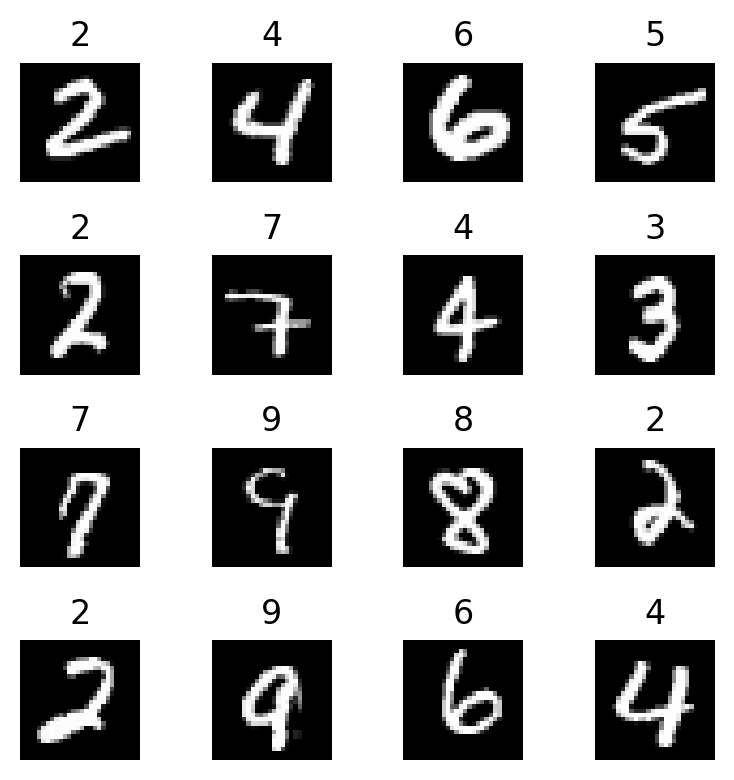

In [4]:
fig = plt.figure(figsize=(4, 4), dpi=200)

for r in range(4):
    for c in range(4):
        idx = np.random.choice(len(mnist_test))
        x, label = mnist_test.data[idx], mnist_test.test_labels[idx]
        ax = fig.add_subplot(4, 4, (r * 4 + c) + 1)
        ax.imshow(x, cmap="gray")
        ax.set_axis_off()
        ax.set_title(label.item())

fig.tight_layout()
fig.canvas.draw()
plt.show()

The Splits class will allow us to specify a Dataset or a DataLoader with their different splits in one place for convinience. The Dataset and Dataloader classes are probided by the PyTorch API and implements helper logics for building and iterating through datasets.

In [5]:
class Splits(NamedTuple):
    train: Dataset | DataLoader
    valid: Dataset | DataLoader | None = None
    test : Dataset | DataLoader | None = None

The images are in the following shape: $(28, 28)$. However, there is a catch. A Multi Layer Perceptron (MLP) only injests flat vectors. We thus have to flatten the latter by reading every value of the image in a contiguous manner. To this end, we reshape the image as part of the transformation api.

In [6]:
mnist_flat = Splits(
    train=MNIST(".datasets", train=True, transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: x.reshape(-1))])),
    test =MNIST(".datasets", train=True, transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: x.reshape(-1))])),
)

In [7]:
mnist_flat_loader = Splits(
    train=DataLoader(mnist_flat.train, batch_size=512, pin_memory=True, num_workers=4, shuffle=True),
    test =DataLoader(mnist_flat.test,  batch_size=512, pin_memory=True, num_workers=4, shuffle=False),
)

### Multi Layer Perceptron

In this section, we implement a simple MLP as a sequence of Linear layers and activations. We volountarly miss the final activation as the Softmax function is included in the loss function we will use. The Softmax function does not modify the order of its input values, it is monotonus. It is thus not required for inference. This little optimization will make inference, the forward pass compute faster.

In [8]:
class MLP(Sequential):
    def __init__(self, in_dim: int, h_dim: int, n_classes: int) -> None:
        super().__init__(
            Linear(in_dim, h_dim), ReLU(),
            Linear(h_dim,  h_dim), ReLU(),
            Linear(h_dim,  n_classes),
        )

### History

The history class is a helper for monitoring the training progress using the error metric, and in our case, for classification, the accuracy for both the train and test steps.

In [9]:
class History:
    def __init__(self) -> None:
        self.loss = []
        self.acc = []

    def __len__(self) -> int:
        assert len(self.loss) == len(self.acc)
        return len(self.loss)

    def plot(self) -> None:
        fig = plt.figure(figsize=(2 * 4, 4), dpi=400)
        ax = fig.add_subplot(2, 1, 1)
        ax.plot(list(range(len(self))), [train for train, test in self.loss], label="train", color="r")
        ax.plot(list(range(len(self))), [test  for train, test in self.loss], label="test",  color="r", linestyle="dashed")
        ax.legend()
        ax.set_title("Loss History")
        ax.set_xlabel("epoch")
        ax.set_ylabel("loss")
        ax.grid(linestyle="--", linewidth=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax = fig.add_subplot(2, 1, 2)
        ax.plot(list(range(len(self))), [train for train, test in self.acc], label="train", color="b")
        ax.plot(list(range(len(self))), [test  for train, test in self.acc], label="test",  color="b", linestyle="dashed")
        ax.legend()
        ax.set_title("Accuracy History")
        ax.set_xlabel("epoch")
        ax.set_ylabel("accuracy in %")
        ax.set_ylim(0.0, 100.0)
        ax.grid(linestyle="--", linewidth=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        fig.canvas.draw()
        fig.tight_layout()
        plt.show()

### Training

In [10]:
def step(model: Module, optim: Optimizer, loaders: Splits, device: str, train: bool = True) -> tuple[float, float]:
    loader = loaders.train if train else loaders.test
    model = model.train(mode=train)
    
    avg_loss, avg_acc = 0.0, 0.0
    for x, label in loader:
        x, label = x.to(device), label.to(device)

        y_: Tensor = model(x)
        loss = F.cross_entropy(y_, label)
        acc = (y_.argmax(dim=-1) == label).sum()

        if train:
            optim.zero_grad(set_to_none=None)
            loss.backward()
            optim.step()

        avg_loss += loss.item() / len(loader)
        avg_acc  += acc.item()  / len(loader.dataset)

    return avg_loss, avg_acc

In [11]:
def fit(model: Module, optim: Optimizer, loaders: Splits, device: str, epochs: int) -> History:
    history = History()

    with tqdm(range(epochs), desc="Epoch") as pbar:
        for epoch in pbar:
            train_loss, train_acc = step(model, optim, loaders, device, train=True)
            test_loss,  test_acc  = step(model, optim, loaders, device, train=False)
            
            history.loss.append((train_loss, test_loss))
            history.acc.append((train_acc * 100, test_acc * 100))
            
            pbar.set_postfix(
                train_loss=f"{train_loss:.2e}",
                test_loss=f"{test_loss:.2e}",
                train_acc=f"{train_acc * 100:.2f}%",
                test_acc=f"{test_acc * 100:.2f}%",
            )

    return history

#### Hyperparameters

Hyperparameters are chosen empirically to showcase good performances.

In [12]:
device = "cuda"
epochs = 10
lr = 1e-3

in_dim = np.prod(mnist_flat.train.data[0].size())
h_dim = 256
n_classes = 10

#### Fit

We now can fit our model on the MNIST dataset using the AdamW optimizer, a variant of the SGD optimizer with second order momentums while monitoring the training and test metrics.

In [13]:
model = MLP(in_dim, h_dim, n_classes).to(device)
optim = AdamW(model.parameters(), lr=lr)

The task is not too difficult to learn for a simple MLP. 

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

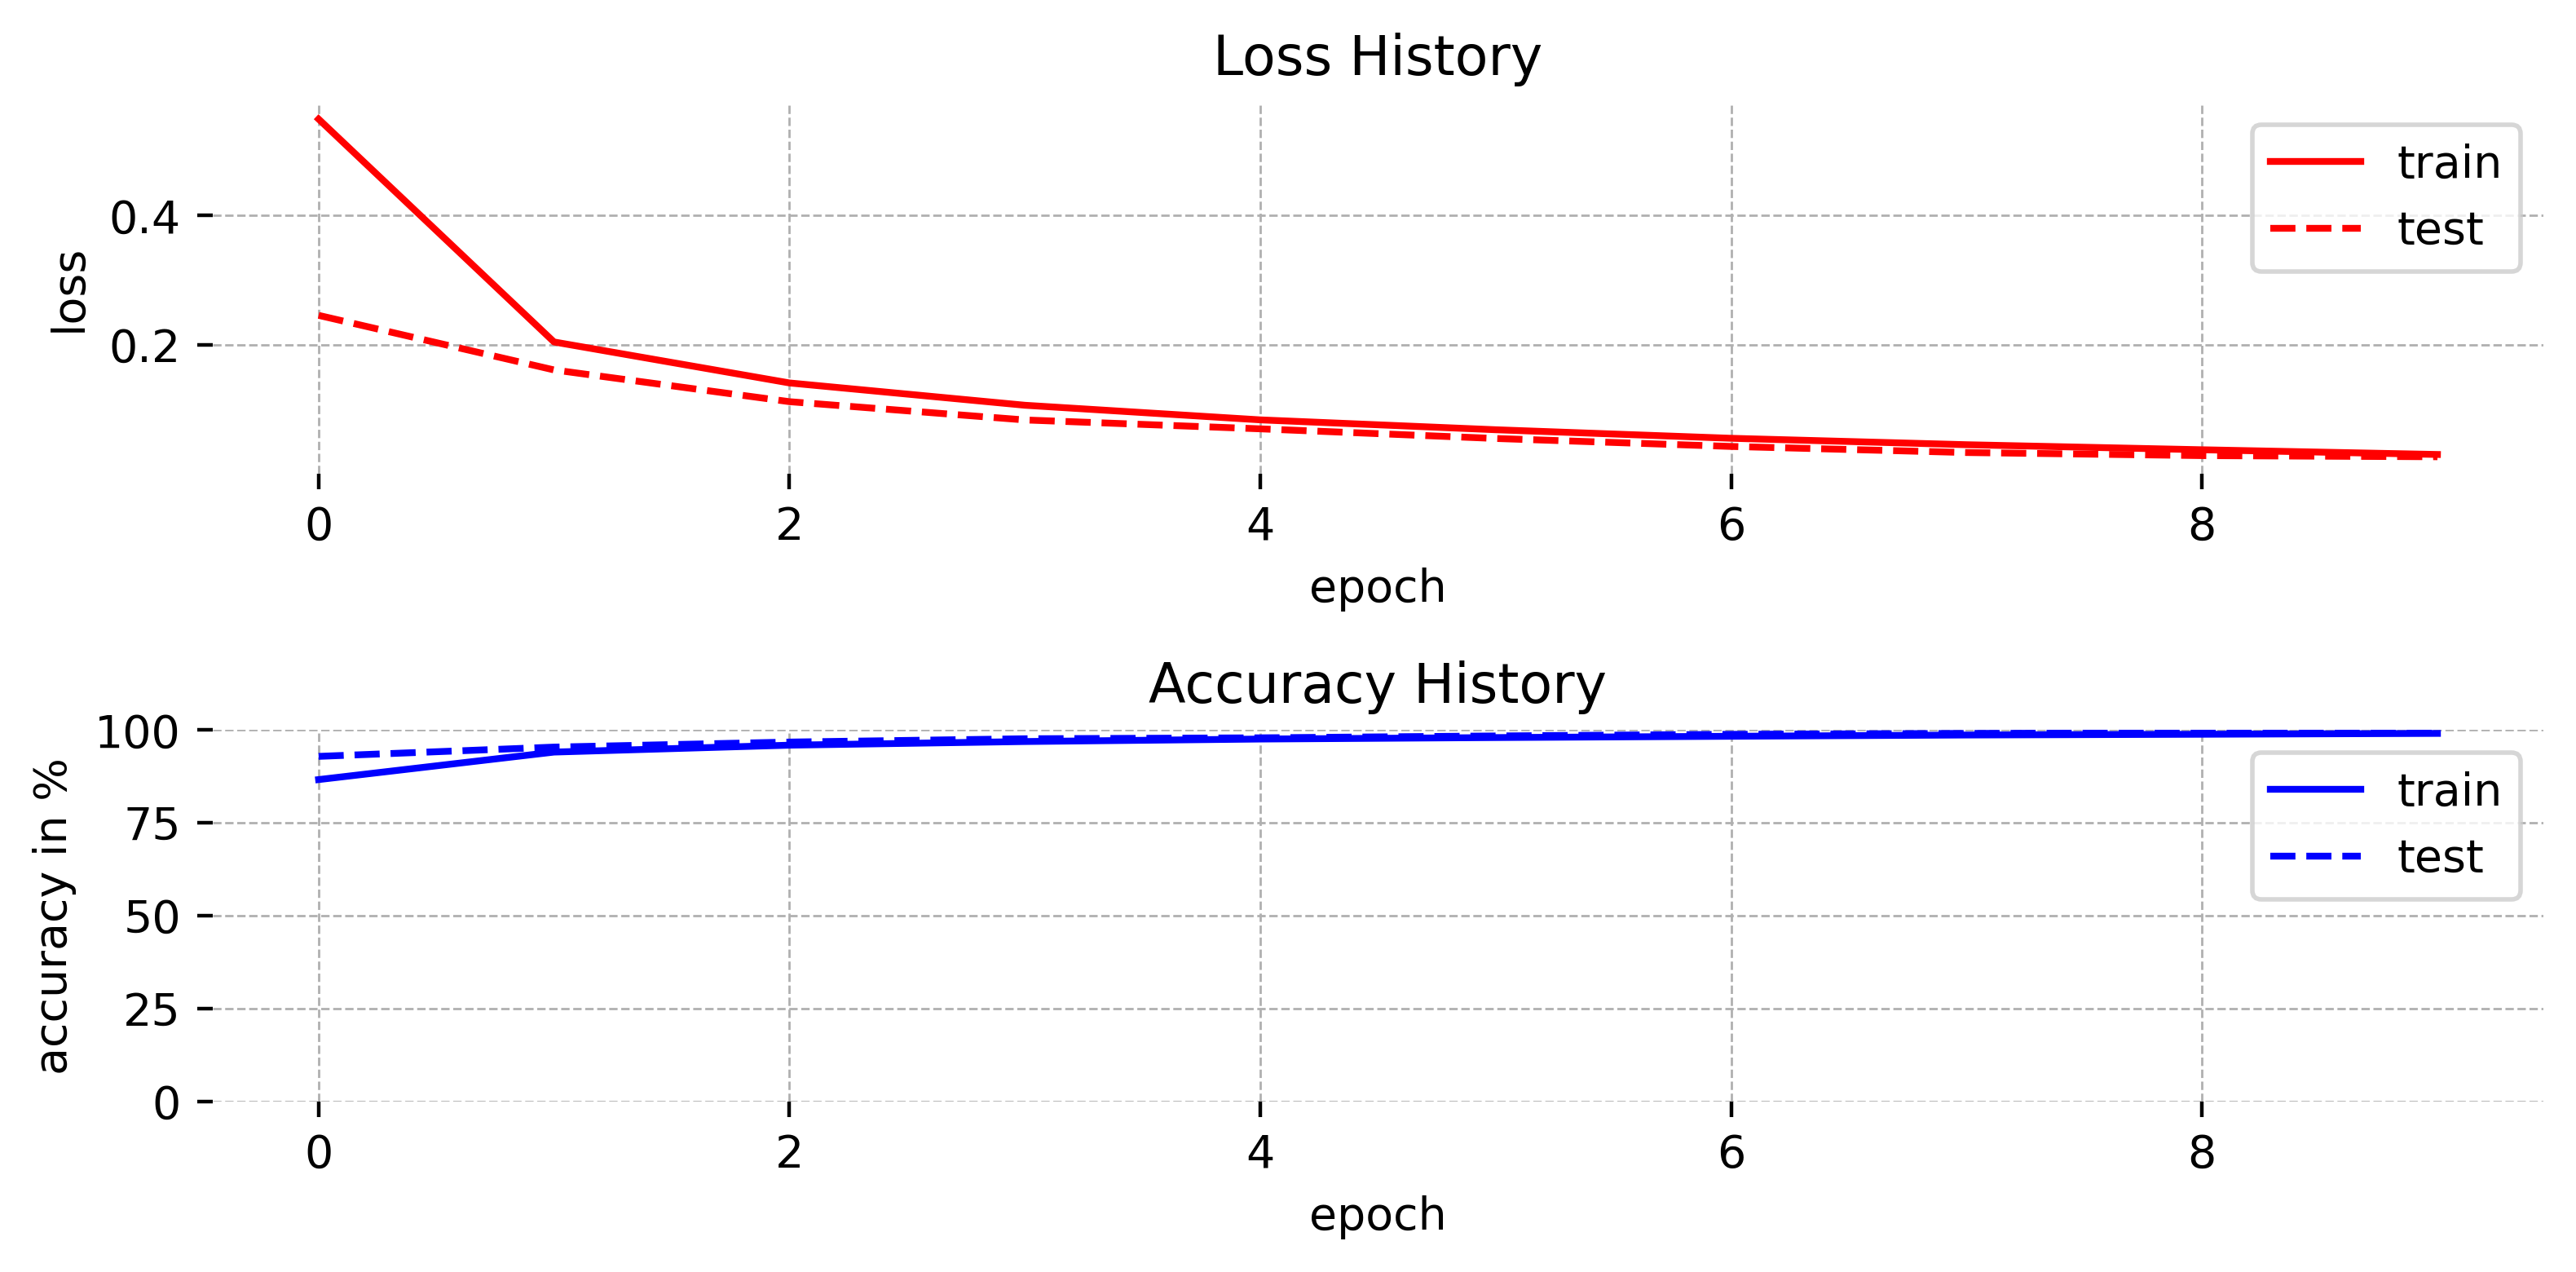

In [14]:
fit(model, optim, mnist_flat_loader, device, epochs).plot()

## MNIST for ConvNets

Know that we have seen how to train a simple model on the MNIST dataset, it is time to introduce the Convolutional Neural Networks, or ConvNets for short. Those networks are a succession of trained filters, the actual Convolutions, activations, and Pooling operations to reduce the dimension of the features. This part of the Network can be referred to as the Feature Extractor and operates on images tensors directly. The output of each convolution operation is a set of Feature Maps that are then used in deeper layers. The final set of feature maps is then flatten to be processed by a Classifier, a simple MLP, a Fully Connected Layer. The advantage of such architecture is that we do not have to build feature descriptors by hand. They are learned in an end to end fashion. This hierarchical sequence of filter operation is inspired by our visual cortex and induce a strong prior into the model architecture and introduces the notion of weight sharing as the filters are common to every set of pixels they go through.

We do not need to flatten the MNIST image tensors anymore. The ToTensor operation transforms a PIL Image into a proper Tensor with values ranging from 0 to 1 and the correct dimension format required by the PyTorch image operators: $(C, H, W)$ for channel (C), height (H), and width (W).

In [15]:
mnist_conv = Splits(
    train=MNIST(".datasets", train=True, transform=T.ToTensor()),
    test =MNIST(".datasets", train=True, transform=T.ToTensor()),
)

In [16]:
mnist_conv_loader = Splits(
    train=DataLoader(mnist_conv.train, batch_size=512, pin_memory=True, num_workers=4, shuffle=True),
    test =DataLoader(mnist_conv.test,  batch_size=512, pin_memory=True, num_workers=4, shuffle=False),
)

### ConvNet

Here we define our Feature Extractor as a succession of 2D Convolutions, ReLU activations, and Max Pooling operations.

In [17]:
class FeatureExtractor(Sequential):
    def __init__(self, in_channels: int) -> None:
        super().__init__(
            Conv2d(1,  8, kernel_size=5), ReLU(), MaxPool2d(2),
            Conv2d(8, 16, kernel_size=5), ReLU(), MaxPool2d(2),
        )

Our Feature Extractor and our MLP can then be combined into a single module, our ConvNet, we call LeNet in homage to Yann LeCun successful ConvNet for digit recognition. We do not forghet to flatten the last set of feature maps to be processed by the MLP.

In [18]:
class LeNet(Module):
    def __init__(self, in_channels: int, in_dim: int, h_dim: int, n_classes: int) -> None:
        super().__init__()
        self.feature_extractor = FeatureExtractor(in_channels)
        self.classifier = MLP(in_dim, h_dim, n_classes)

    def forward(self, x: Tensor) -> Tensor:
        x = self.feature_extractor(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x

This function is a little helper that computes the final feature maps output size when flattened. Its is used to indicate the number of input dimensions to the MLP.

In [19]:
def compute_in_dim(x: Tensor) -> int:
    b, c, h, w = x.size()
    feature_extractor = FeatureExtractor(c).to(x.device)
    features = feature_extractor(x)
    features = features.flatten(1)
    return features.size(1)

### Hyperparametes

In [20]:
device = "cuda"
epochs = 10
lr = 1e-3

in_channels = 1
in_dim = compute_in_dim(torch.rand((1, 1, 28, 28), dtype=torch.float32))
h_dim = 256
n_classes = 10

### Fit

In [21]:
model = LeNet(in_channels, in_dim, h_dim, n_classes).to(device)
optim = AdamW(model.parameters(), lr=lr)

In this example, with a small and simple image dataset, the advantage of using a ConvNet over a MLP is not well represented. But imagine having a 512x512 image. It would require us to pass a $262,144$ size vector to the MLP and would result in huge matrix operations. This is where the ConvNets are shinning. They more efficient at processing images or more generally multidimensional Tensors.

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

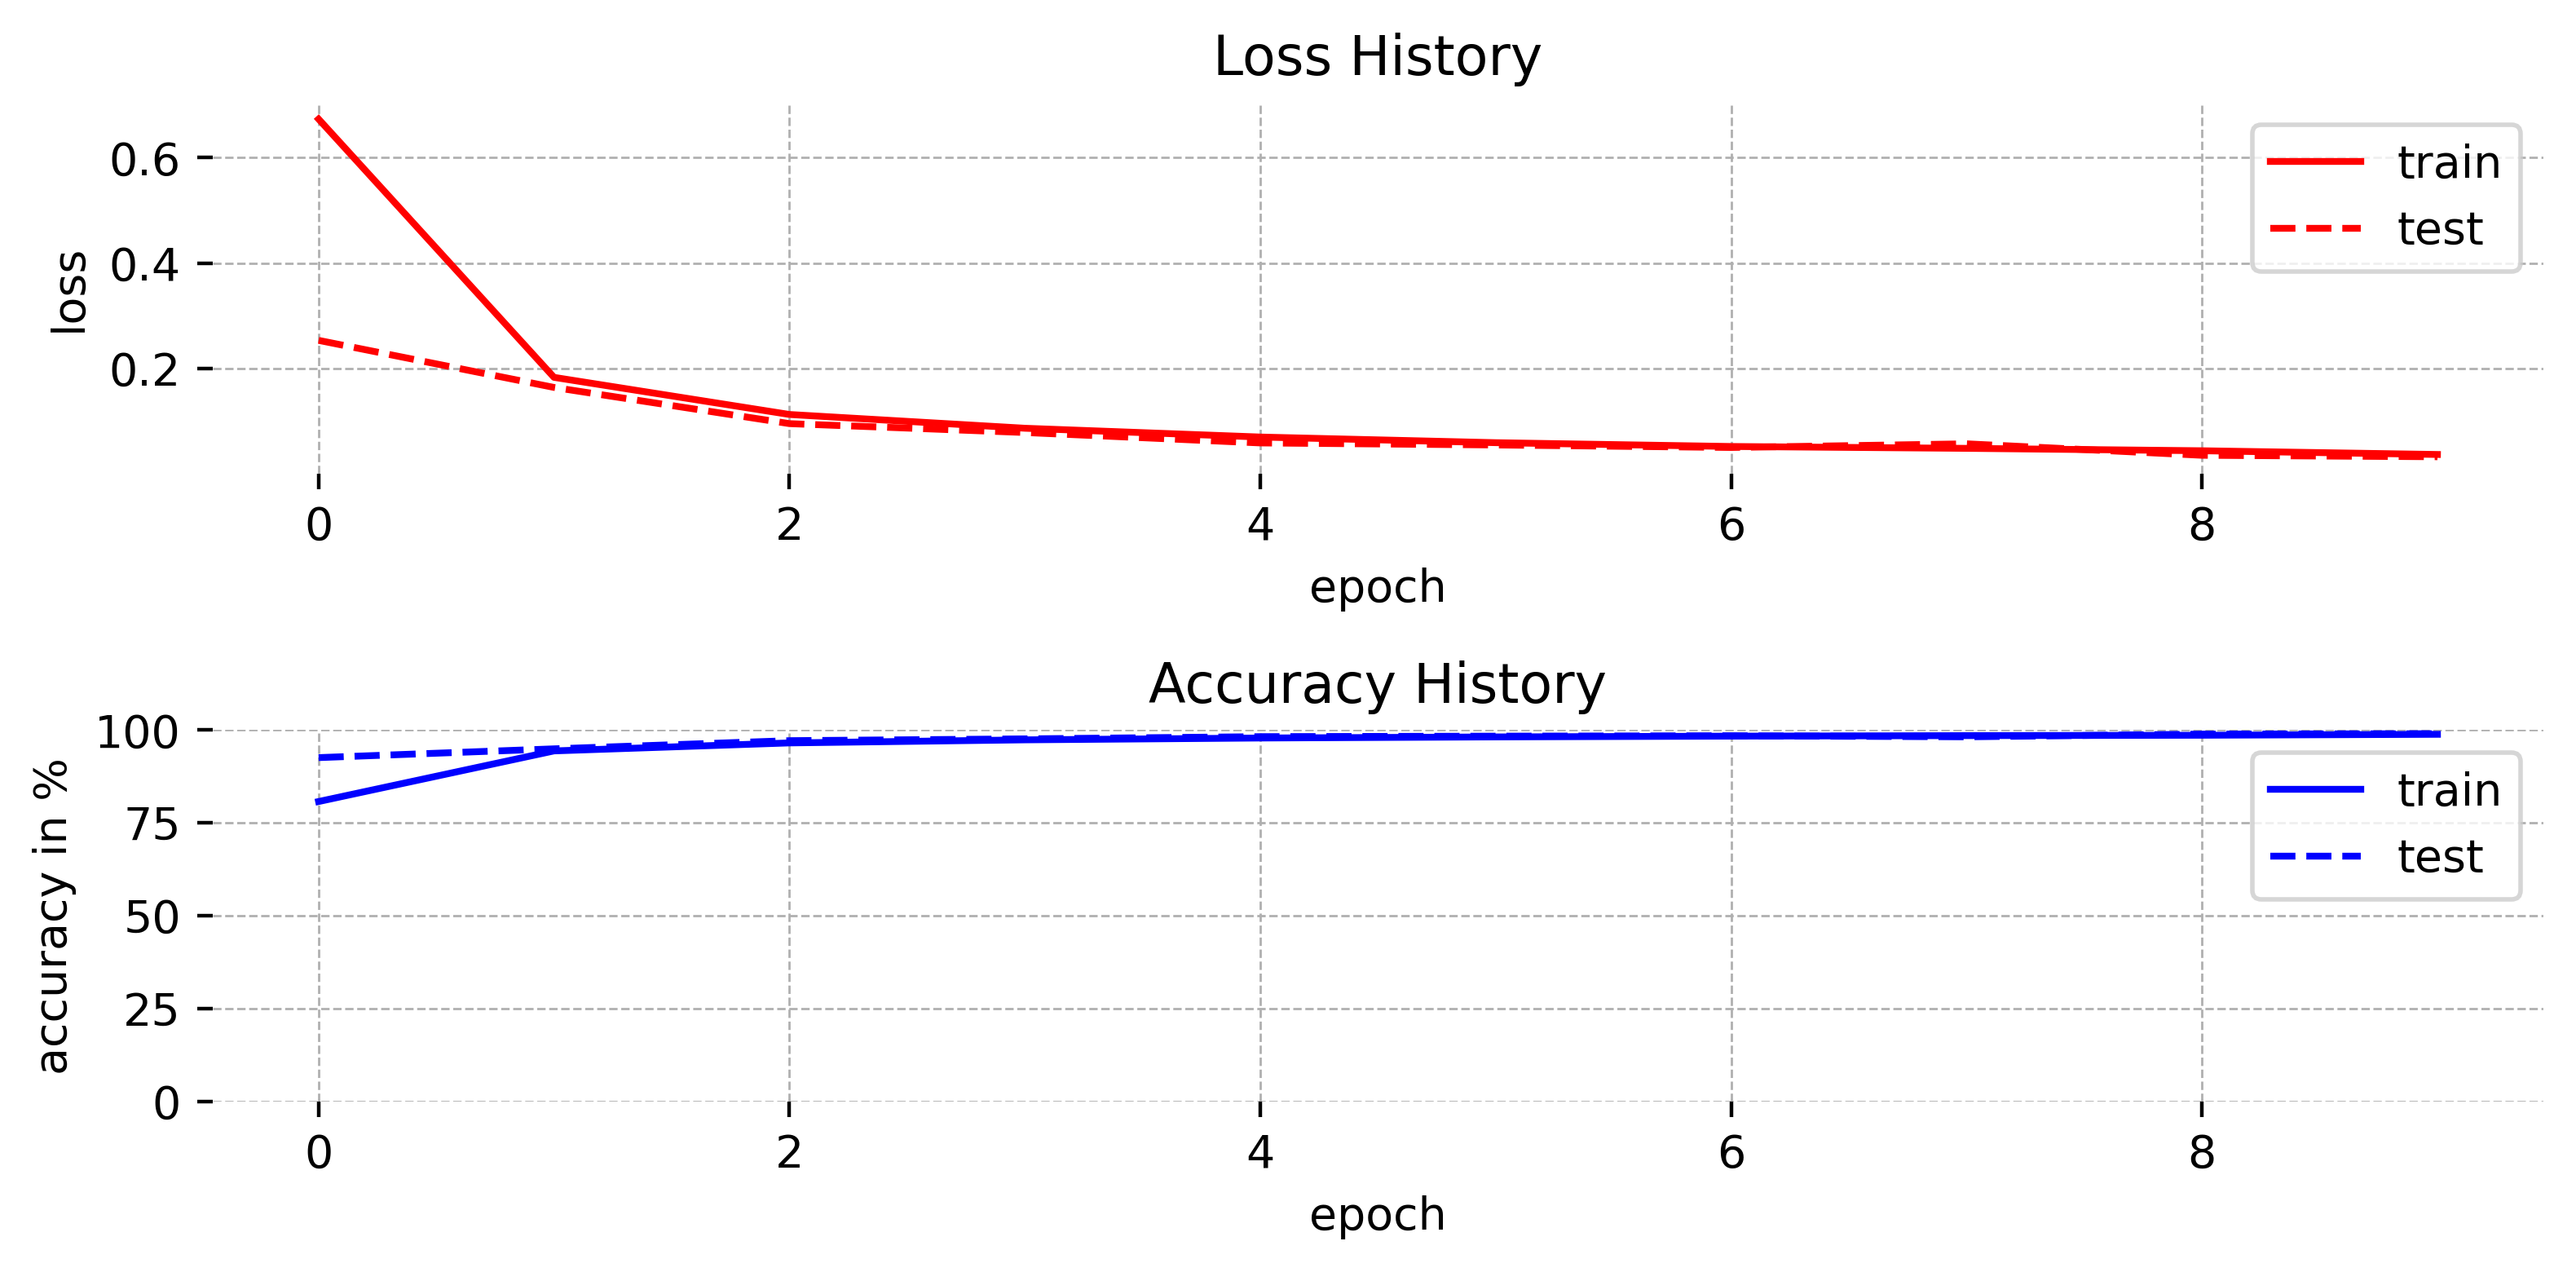

In [22]:
fit(model, optim, mnist_conv_loader, device, epochs).plot()

### Augmentation

In this final example we demonstrate a simple technique called Augmentation used to augment the variety of input data present in a given dataset. It allows us to make our model more robust to some variations in the input and acts as a sort of regularization for the model.

In [38]:
mnist_conv_aug = Splits(
    train=MNIST(".datasets", train=True, transform=T.Compose([T.RandAugment(), T.ToTensor()])),
    test =MNIST(".datasets", train=True, transform=T.ToTensor()),
)

In [24]:
mnist_conv_aug_loader = Splits(
    train=DataLoader(mnist_conv_aug.train, batch_size=512, pin_memory=True, num_workers=4, shuffle=True),
    test =DataLoader(mnist_conv_aug.test,  batch_size=512, pin_memory=True, num_workers=4, shuffle=False),
)

In [25]:
device = "cuda"
epochs = 10
lr = 1e-3

in_channels = 1
in_dim = compute_in_dim(torch.rand((1, 1, 28, 28), dtype=torch.float32))
h_dim = 256
n_classes = 10

In [26]:
model = LeNet(in_channels, in_dim, h_dim, n_classes).to(device)
optim = AdamW(model.parameters(), lr=lr)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

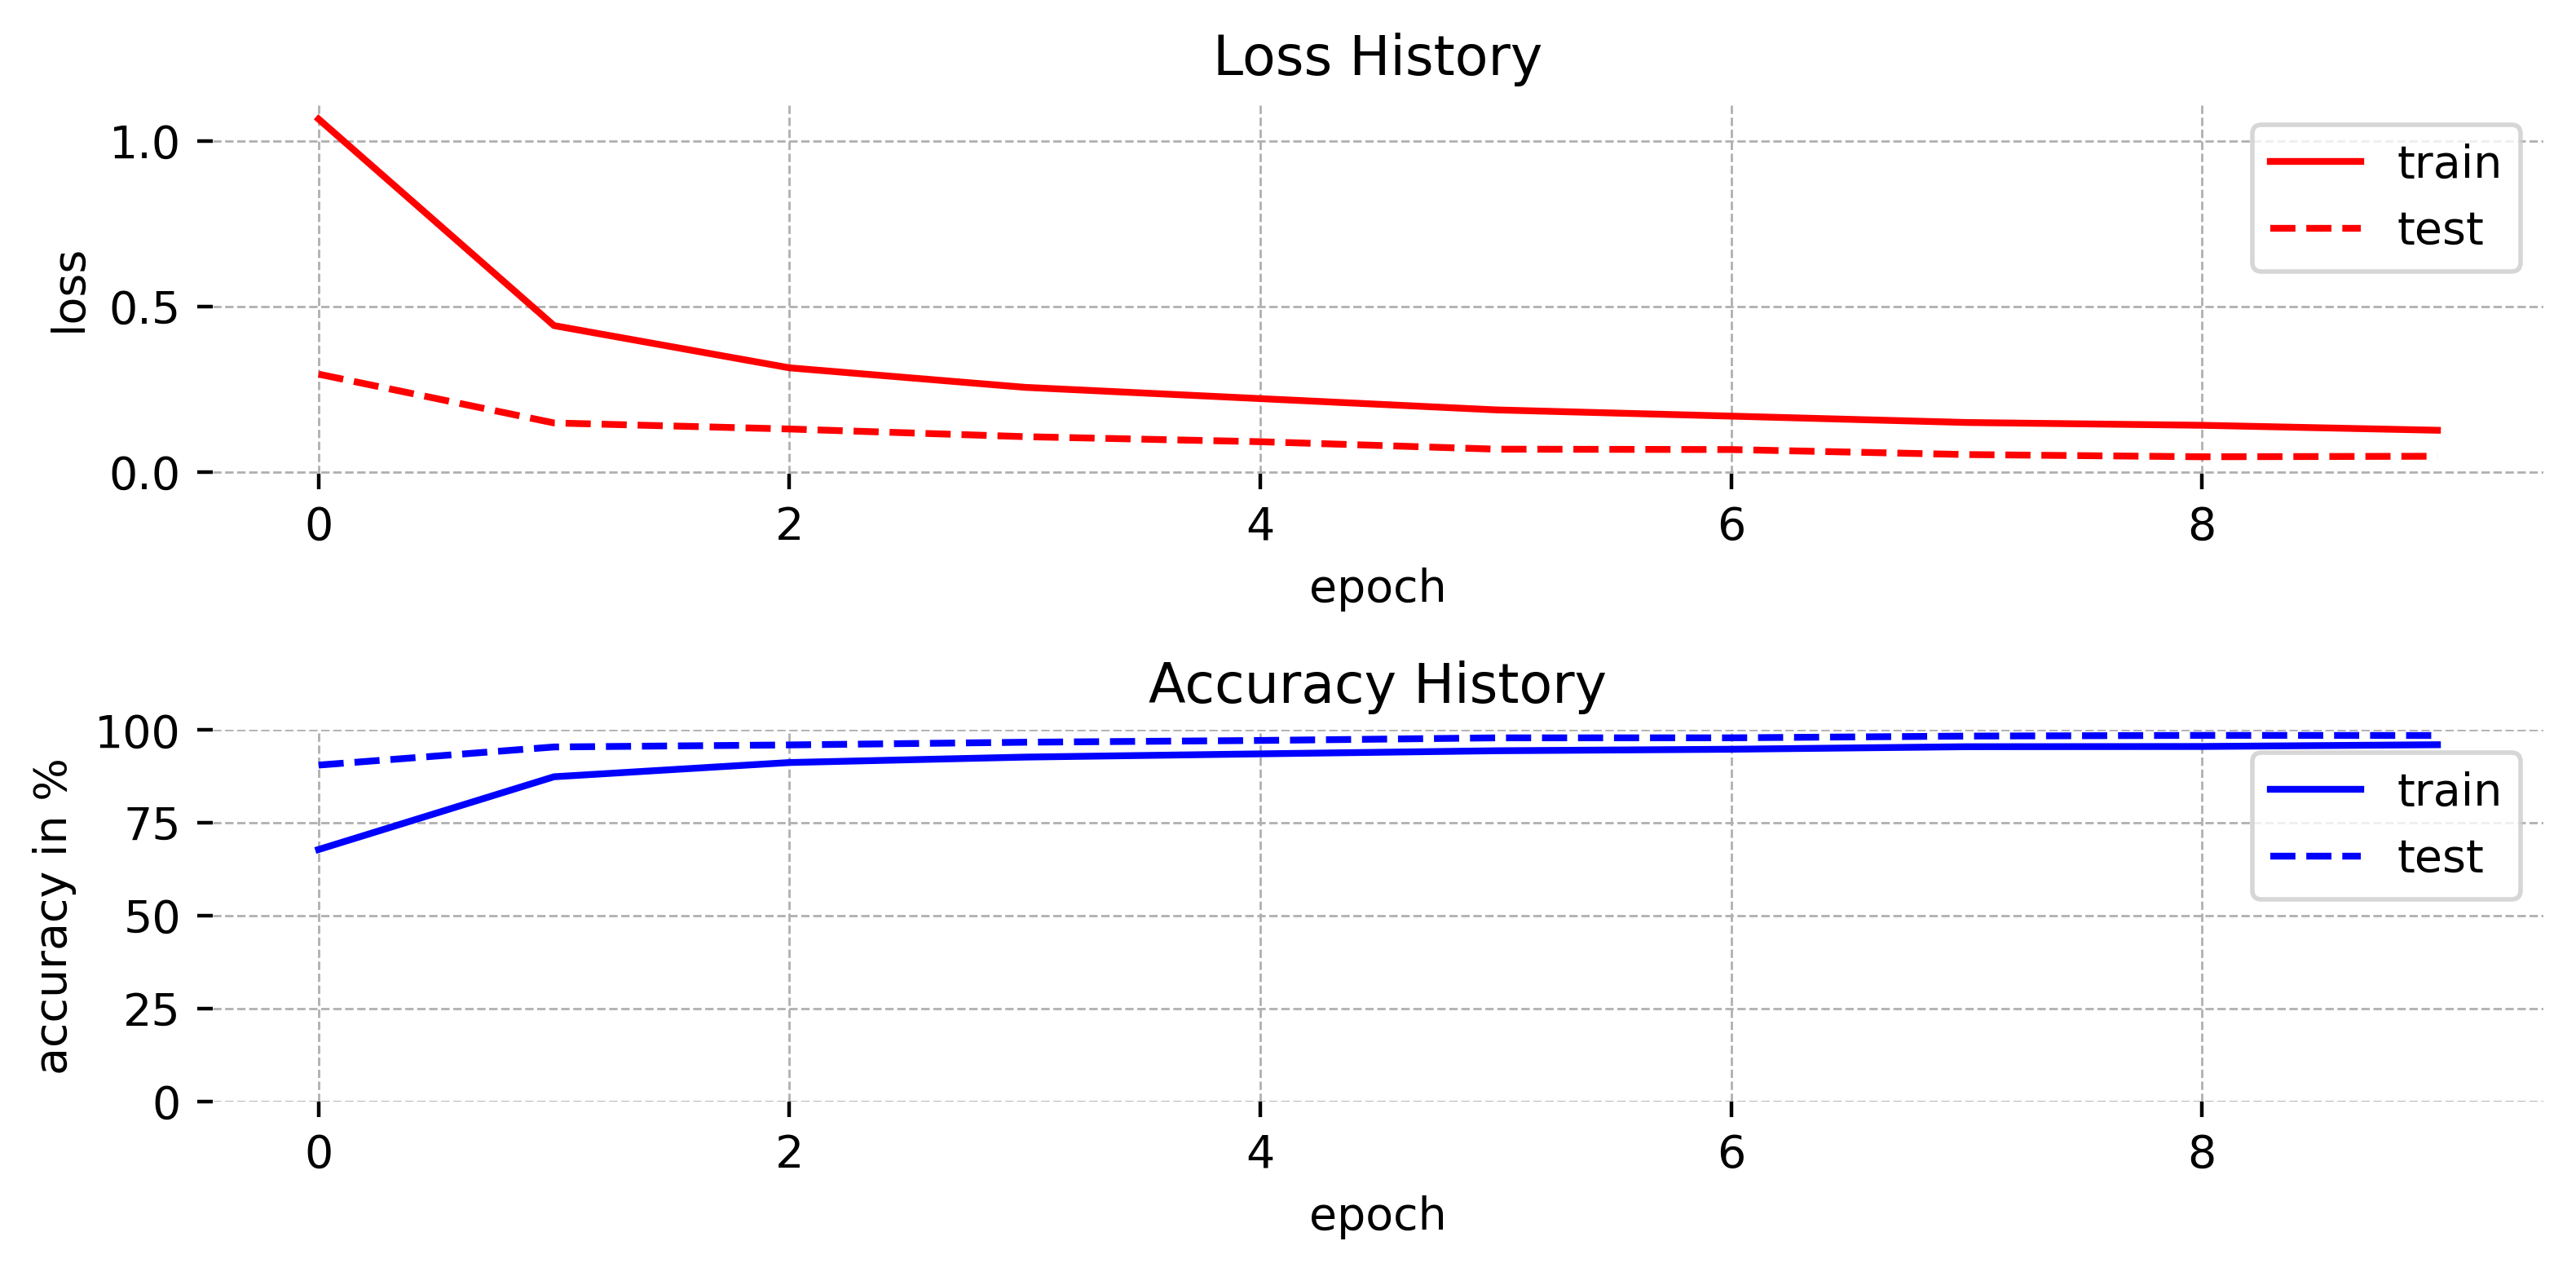

In [27]:
fit(model, optim, mnist_conv_aug_loader, device, epochs).plot()

## CIFAR 10

Let us handle a more complex example. Here we introduce the CIFAR 10 dataset. A dataset of 32x32 RGB images of ten classes, cars, airplanes, and more. This dataset is more challenging than MNIST and we serve as the illustration point for introducing the notion of finetuning.

Finetuning consists in taking a pretrained model, trained on a huge and general dataset (e.g. ImageNet for images), and retraining the ConvNet classifier only. This allows us to train faster, as the models already comes with pretrained filters that are general enough to be useful for classifying more specific images. With this approach, the model needs less data to be trained. This is usefull for training deep learning models on specialized tasks with low data available (e.g. Super Nova photographies).

This is equivalent to training a child on general Maths and then training him on a specialized subfield of Mathematics. As the chil already has acquired general knowledge on computation and logic, the task is easier to tackle.

In [39]:
cifar_train = CIFAR10(".datasets", download=True, train=True)
cifar_test  = CIFAR10(".datasets", download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
print("CIFAR dataset size :", len(cifar_train), len(cifar_test))
print("CIFAR img     shape:", tuple(cifar_test.data[0].shape))

CIFAR dataset size : 50000 10000
CIFAR img     shape: (32, 32, 3)


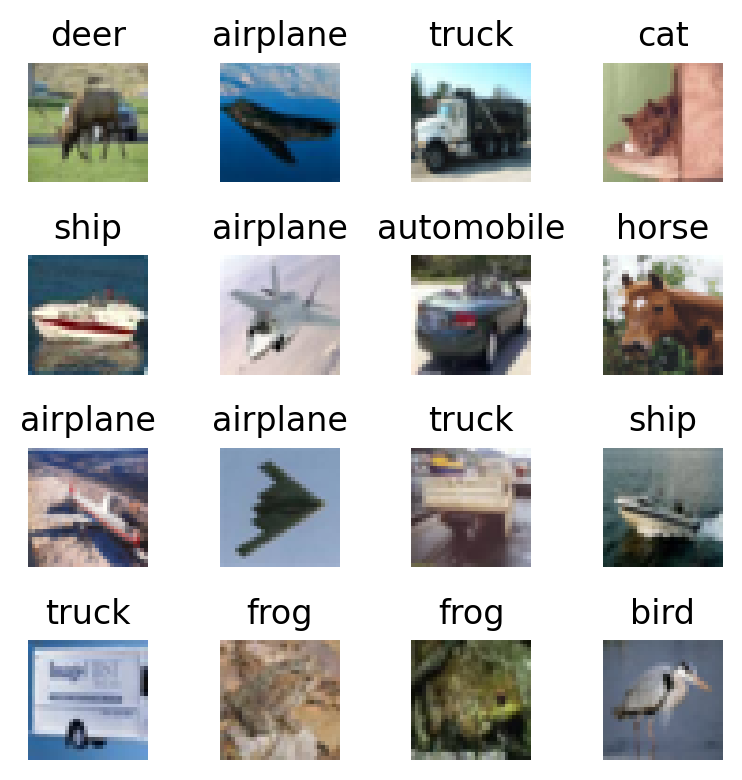

In [30]:
fig = plt.figure(figsize=(4, 4), dpi=200)

for r in range(4):
    for c in range(4):
        idx = np.random.choice(len(cifar_test))
        x, label = cifar_test.data[idx], cifar_test.targets[idx]
        ax = fig.add_subplot(4, 4, (r * 4 + c) + 1)
        ax.imshow(x)
        ax.set_axis_off()
        ax.set_title(cifar_test.classes[label])

fig.tight_layout()
fig.canvas.draw()
plt.show()

### Preparing the Dataset

For this example, we normalize every image to remove their shared information. Its has the purpose of simplifying the task by making the network only learn what is different in the dataset.

In [31]:
normalize = T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
prepare = T.Compose([T.ToTensor(), normalize])

In [32]:
cifar_conv_aug = Splits(
    train=CIFAR10(".datasets", train=True, transform=T.Compose([T.RandomHorizontalFlip(), T.RandAugment(), prepare])),
    test =CIFAR10(".datasets", train=True, transform=prepare),
)

In [33]:
cifar_conv_aug_loader = Splits(
    train=DataLoader(cifar_conv_aug.train, batch_size=256, pin_memory=True, num_workers=4, shuffle=True),
    test =DataLoader(cifar_conv_aug.test,  batch_size=256, pin_memory=True, num_workers=4, shuffle=False),
)

In [34]:
device = "cuda"
epochs = 30
lr = 1e-3

n_classes = 10

### ResNet

In this subsection we finetune a model pretrained on ImageNet called [ResNet](https://arxiv.org/abs/1512.03385). Its is one of the most popular architecture used for vision pattern extraction and introduces the notion of skip conenctions, or residual connections, to limit phenomenas such as exploding and vanishing gradients due to the deepness of large neural models.

In [40]:
resnet = resnet18(pretrained=True, progress=True)
resnet.fc = Linear(resnet.fc.in_features, n_classes)

In [36]:
model = resnet.to(device)
optim = AdamW(model.parameters(), lr=lr)

In a few number of epochs, the model is able to learn how to differentiate the CIFAR 10 images.

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

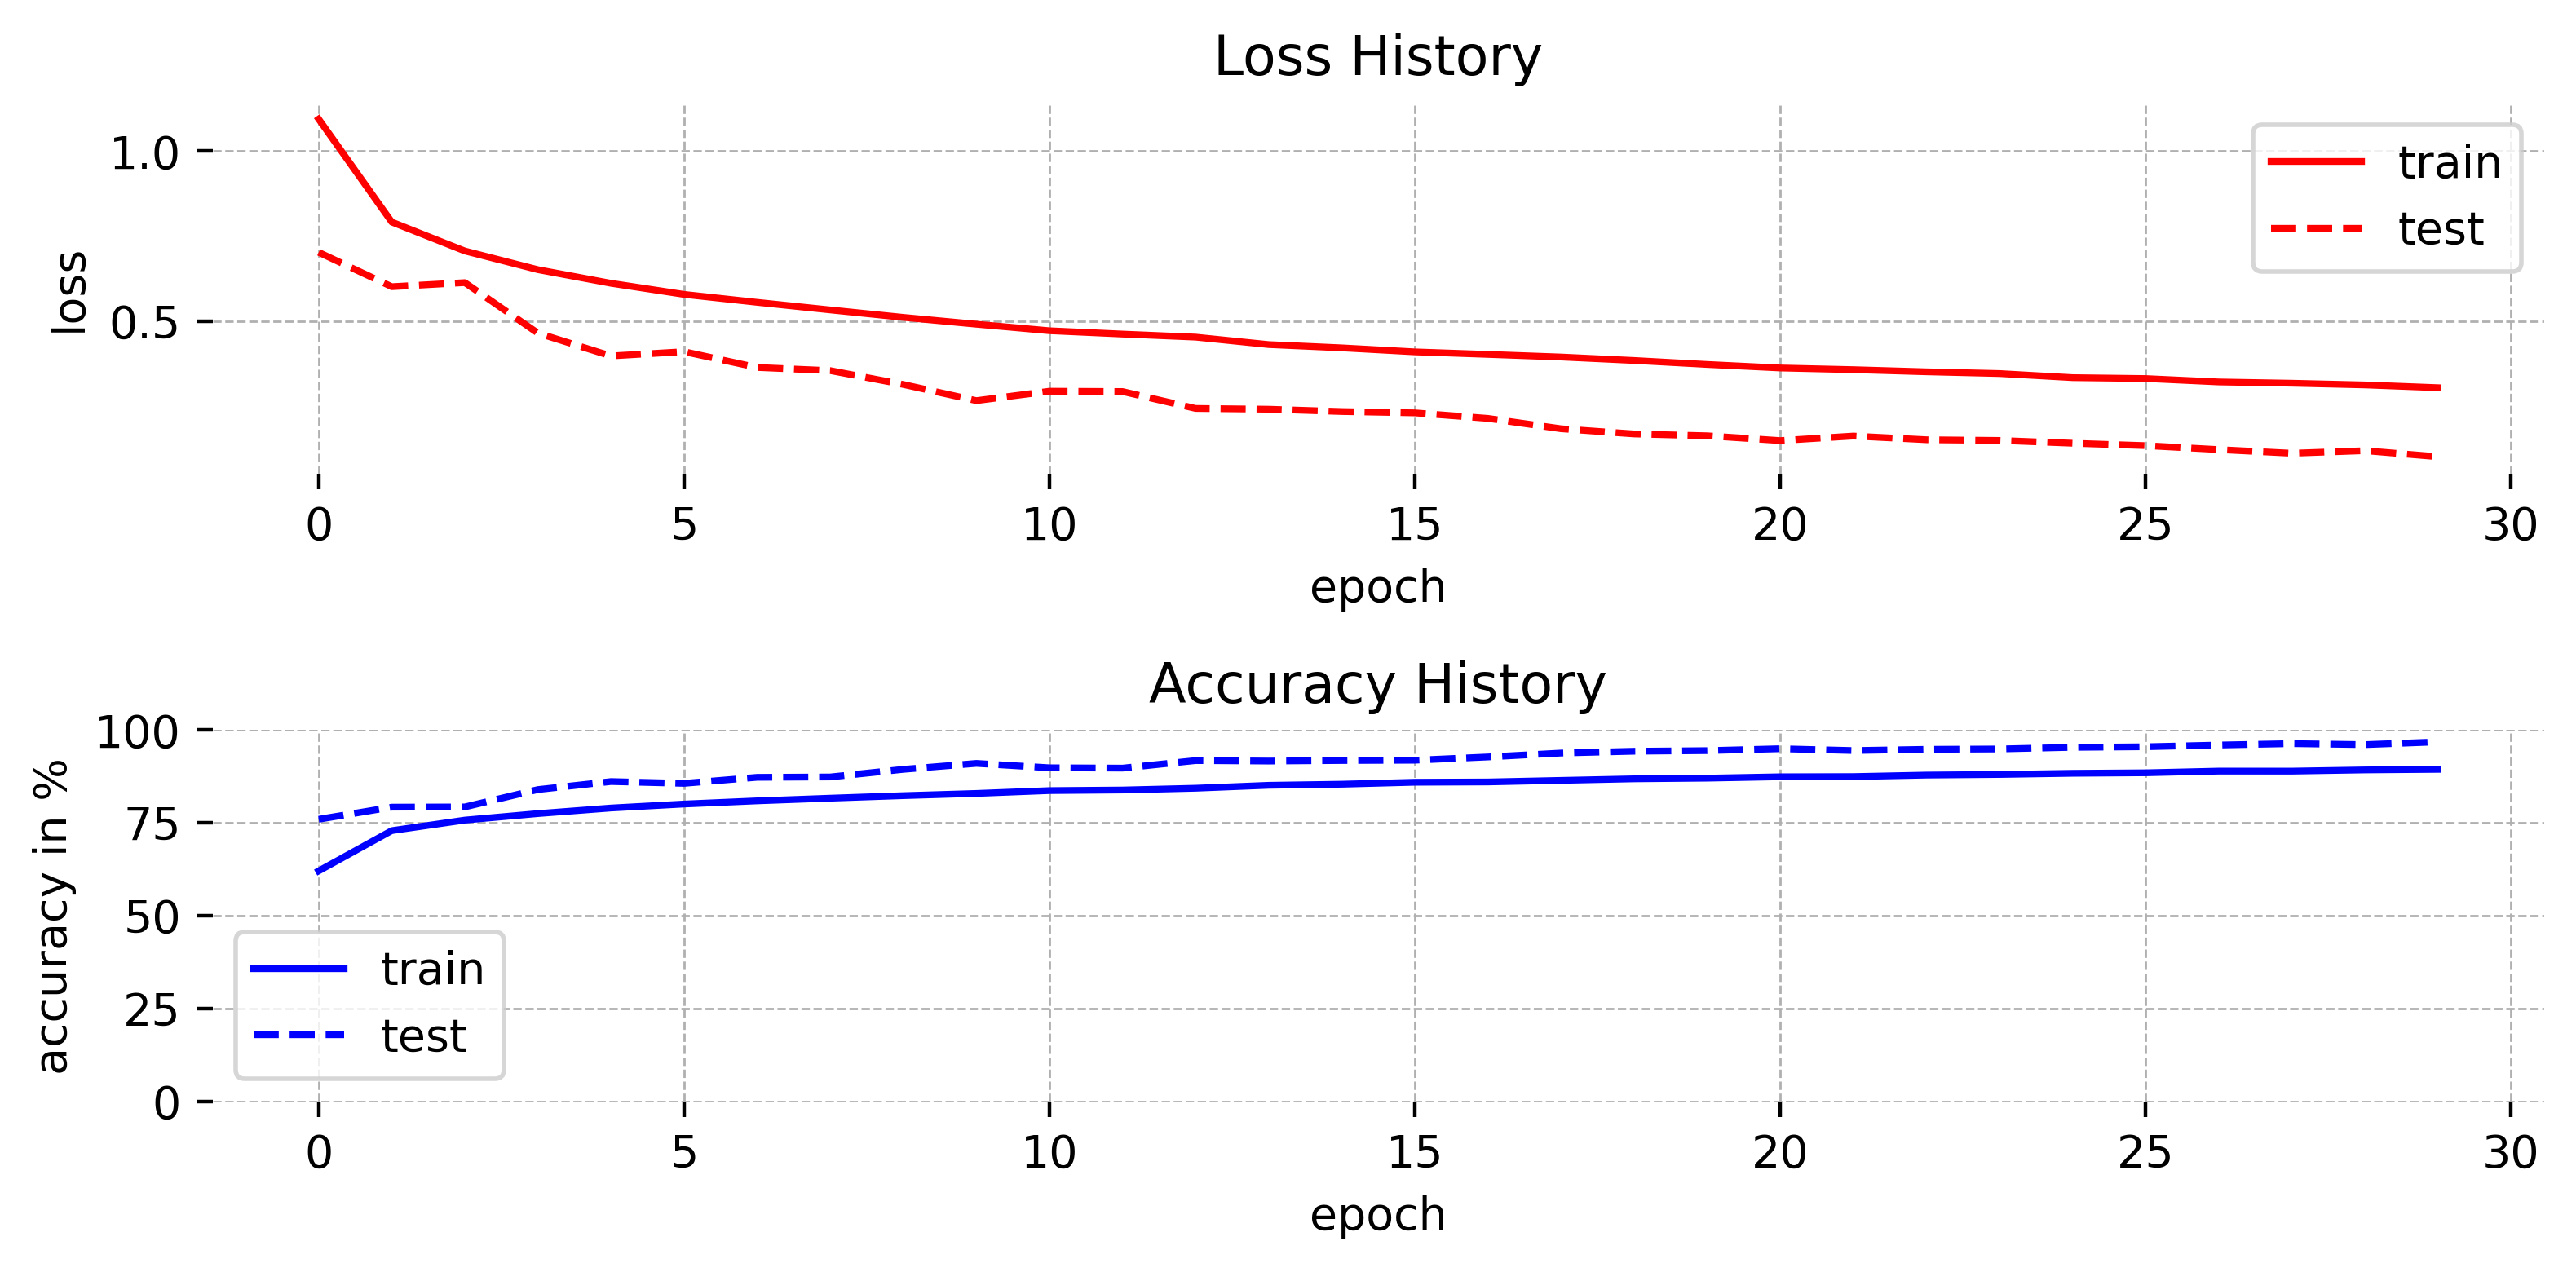

In [37]:
fit(model, optim, cifar_conv_aug_loader, device, epochs).plot()